## The Maximum Independent Set


Let's do an end-to-end example, using Bloqade to solve a paradigmatic problem of graph theory: the Maximum Independent Set (MIS). Given a graph with nodes (say we color them in white) and some edges between them, to find an MIS is to color the largest possible subset of nodes (say in red) not connected among themselves by edges. Our MIS should simply be a set of red nodes with no edges between them. How do we solve these with atoms?

As usual, let's just start prepping the grounds

In [28]:
using Bloqade
using Random
using PythonCall
using Optim
using GenericTensorNetworks
using GenericTensorNetworks: unit_disk_graph
using PythonCall
using Random

plt = pyimport("matplotlib.pyplot");

# Adiabatic Solution
## Set up the Graph

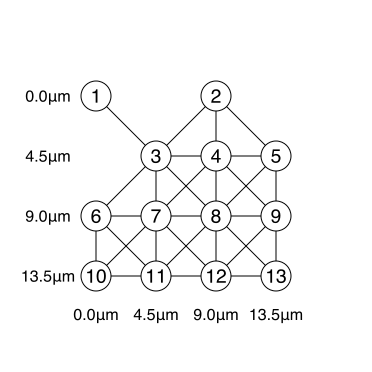

In [2]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)
Rb=sqrt(2*sqrt(2))*a
Bloqade.plot(atoms, blockade_radius = Rb)

## Set up the Delta Ω and Δ 

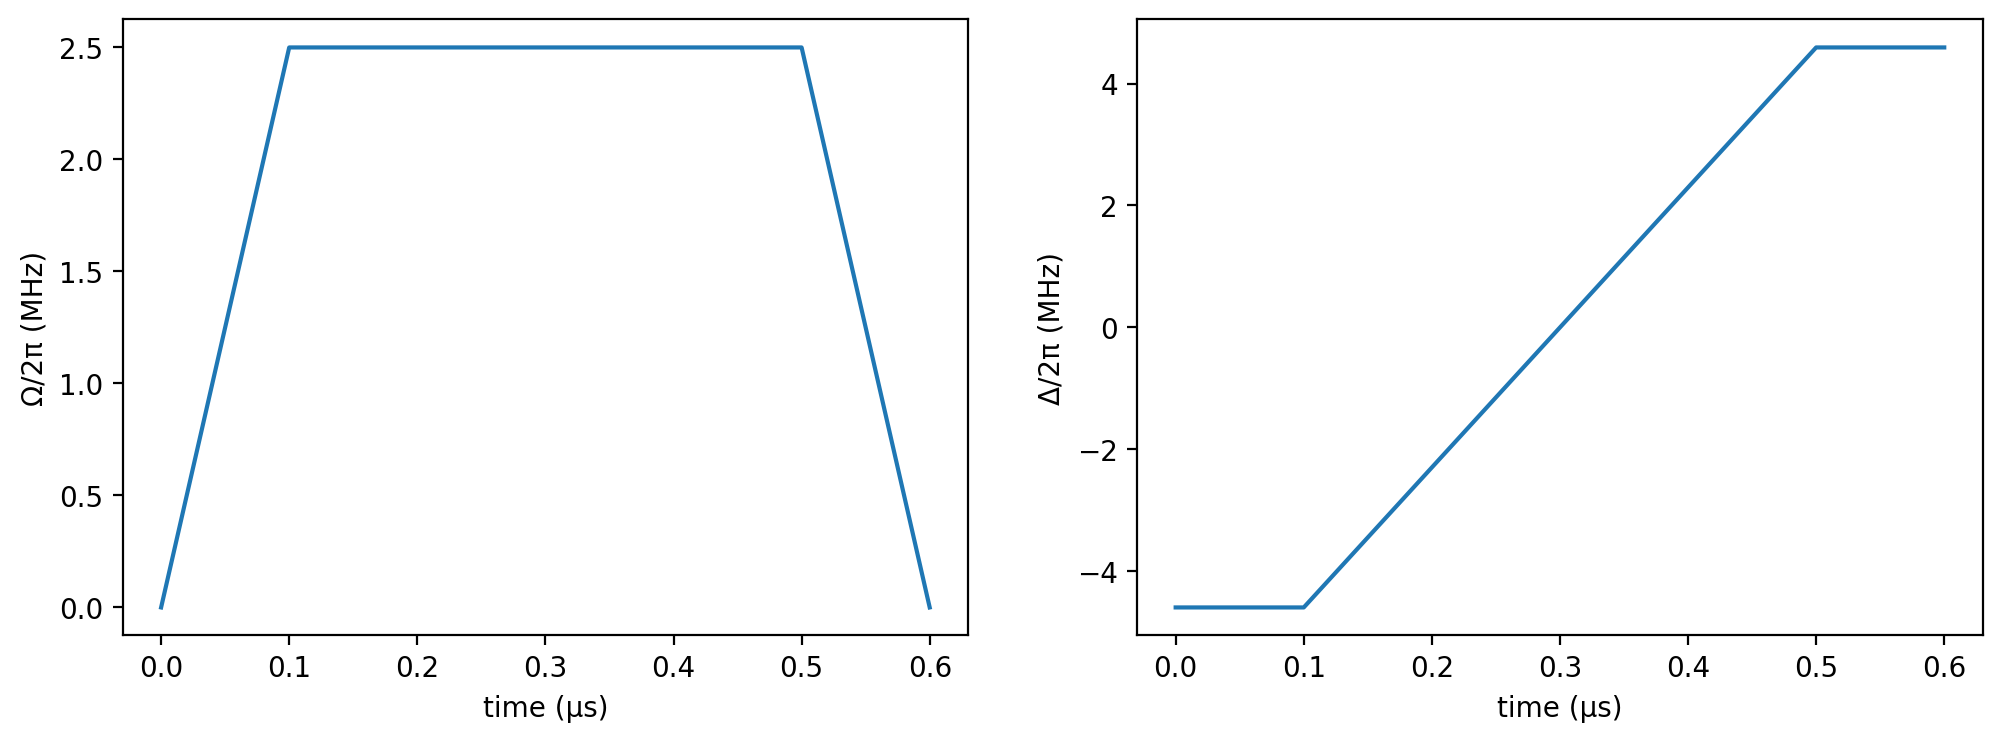

In [3]:
#Total evolution time
T_max = 0.6

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Optimizing these time traces can improve the convergence and likelihood of finding the MIS, but this will do for now. 

We initialize the problem with the parameters above, including a "zero_state" initial register for the Hamiltonian's qubits.

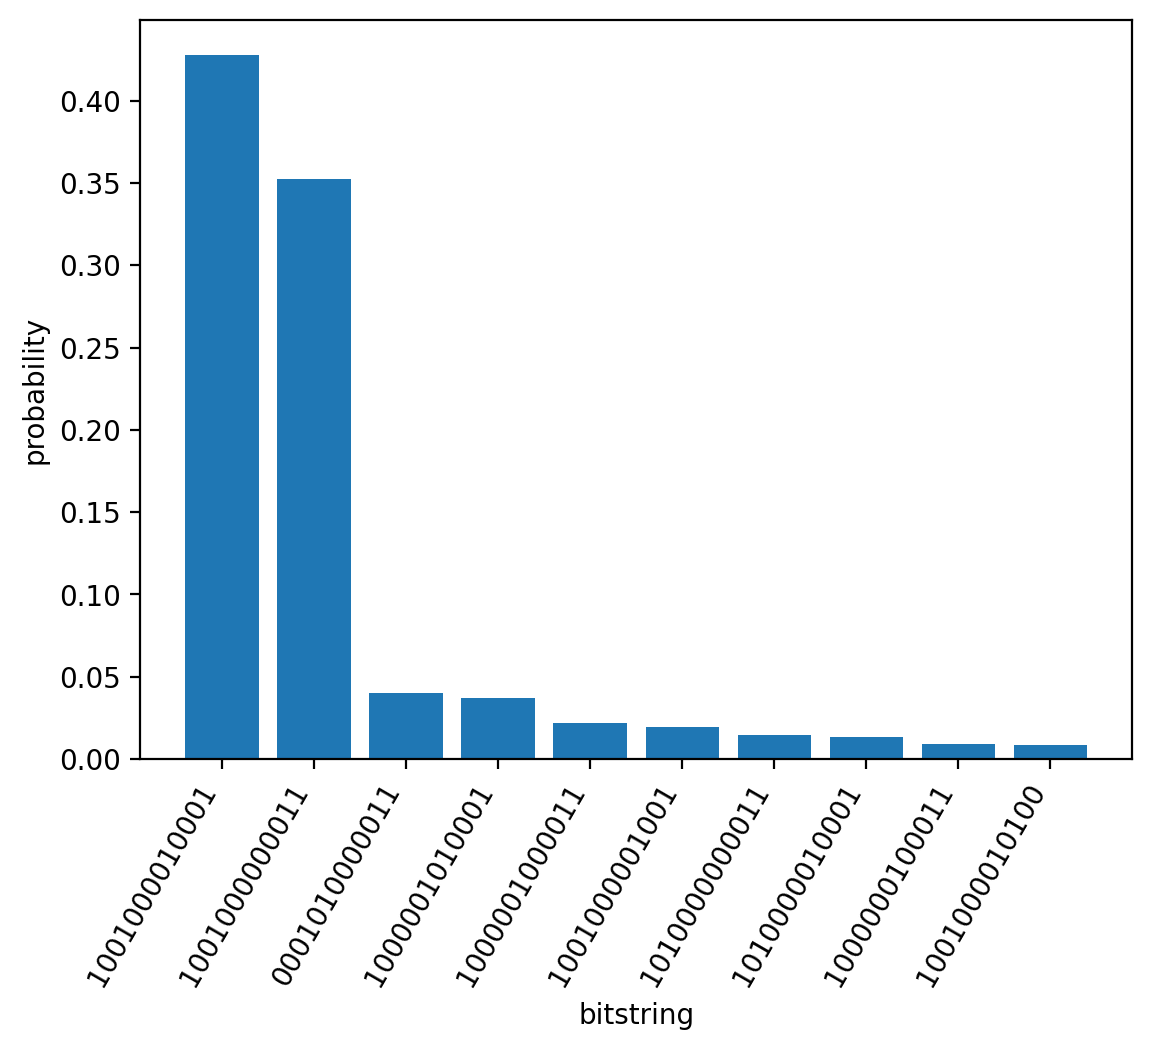

In [29]:
h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);
emulate!(prob)
bitstring_hist(prob.reg; nlargest = 10)

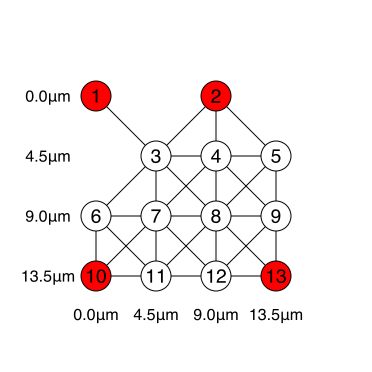

In [7]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

# Optimization to get optimal Δ and Ω

### Helper functions for optimizations 

In [32]:
## Taking a set of parameters (t_start, t_end, and scale), it returns omega and delta
function get_waves(params::Vector{Float64}) # returns the pulses as a function of certain parameters
    t_start, t_end, scale... = params
    t_start+=0.03
    T_max = 0.6
    t_end = T_max - t_end - 0.03
    t_interval = (t_end - t_start) / (length(scale) + 1)
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = Δ0 = 11 * 2π

    Δ_clock = [0.0, t_start]
    Δ_val = [Δ_start, Δ_start]
    for i in 1:length(scale)
        push!(Δ_val, Δ0*scale[i])
        push!(Δ_clock, t_start + i*t_interval)
    end
    push!(Δ_val, Δ_end); push!(Δ_val, Δ_end)
    push!(Δ_clock, t_end); push!(Δ_clock, T_max)
    Δ = piecewise_linear(clocks = Δ_clock, values = Δ_val);
    Ω = piecewise_linear(clocks = [0.0, t_start, t_end, T_max], values = [0, Ω_max, Ω_max, 0]);
    return Ω, Δ
end

## Given parameters, create the waves calling get_waves and plot them
function plot_waves(params::Vector{Float64})
    Ω, Δ = get_waves(params)

    graph, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
    Bloqade.plot!(ax1, Ω)
    ax1.set_ylabel("Ω/2π (MHz)")
    Bloqade.plot!(ax2, Δ)
    ax2.set_ylabel("Δ/2π (MHz)")
    return graph
end

x0 = [0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

plot_waves(x0)

## Compare the results of the classical solution and the quantum solution and returns the probability of finding MIS? 
function get_MIS_prob(reg::Union{ArrayReg, SubspaceArrayReg}, configs) # want to maxmimize this
    prob = 0
    x = [parse(Int, reverse(string(x)); base=2) for x in configs.c]
    for (c, amp) in BloqadeMIS.ConfigAmplitude(reg)
        if c in x
            prob+=abs2(amp)
        end
    end
    return prob
end

## gets atom placement, parameters, and classical solutions 
## create the subspace, create the schrodinger problem and and emulate it, compare the results of the quantum vs classical method 
## return the probability  
function loss(atoms::AtomList, x::Vector{Float64}, configs)
    Ω, Δ = get_waves(x)
    hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
    subspace = blockade_subspace(atoms, 4.5)
    prob = SchrodingerProblem(zero_state(subspace), T_max, hamiltonian)
    emulate!(prob)
    return -get_MIS_prob(prob.reg, configs), prob.reg, Δ
end

loss (generic function with 1 method)

## Set up the problem 

In [25]:
R = 7.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

unit_graph = unit_disk_graph(atoms, R)

configs = GenericTensorNetworks.solve(IndependentSet(unit_graph), ConfigsMax())[]
optresult = Optim.optimize(x -> loss(atoms, x, configs)[1], x0)

 * Status: success

 * Candidate solution
    Final objective value:     -9.668047e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    748
    f(x) calls:    1125


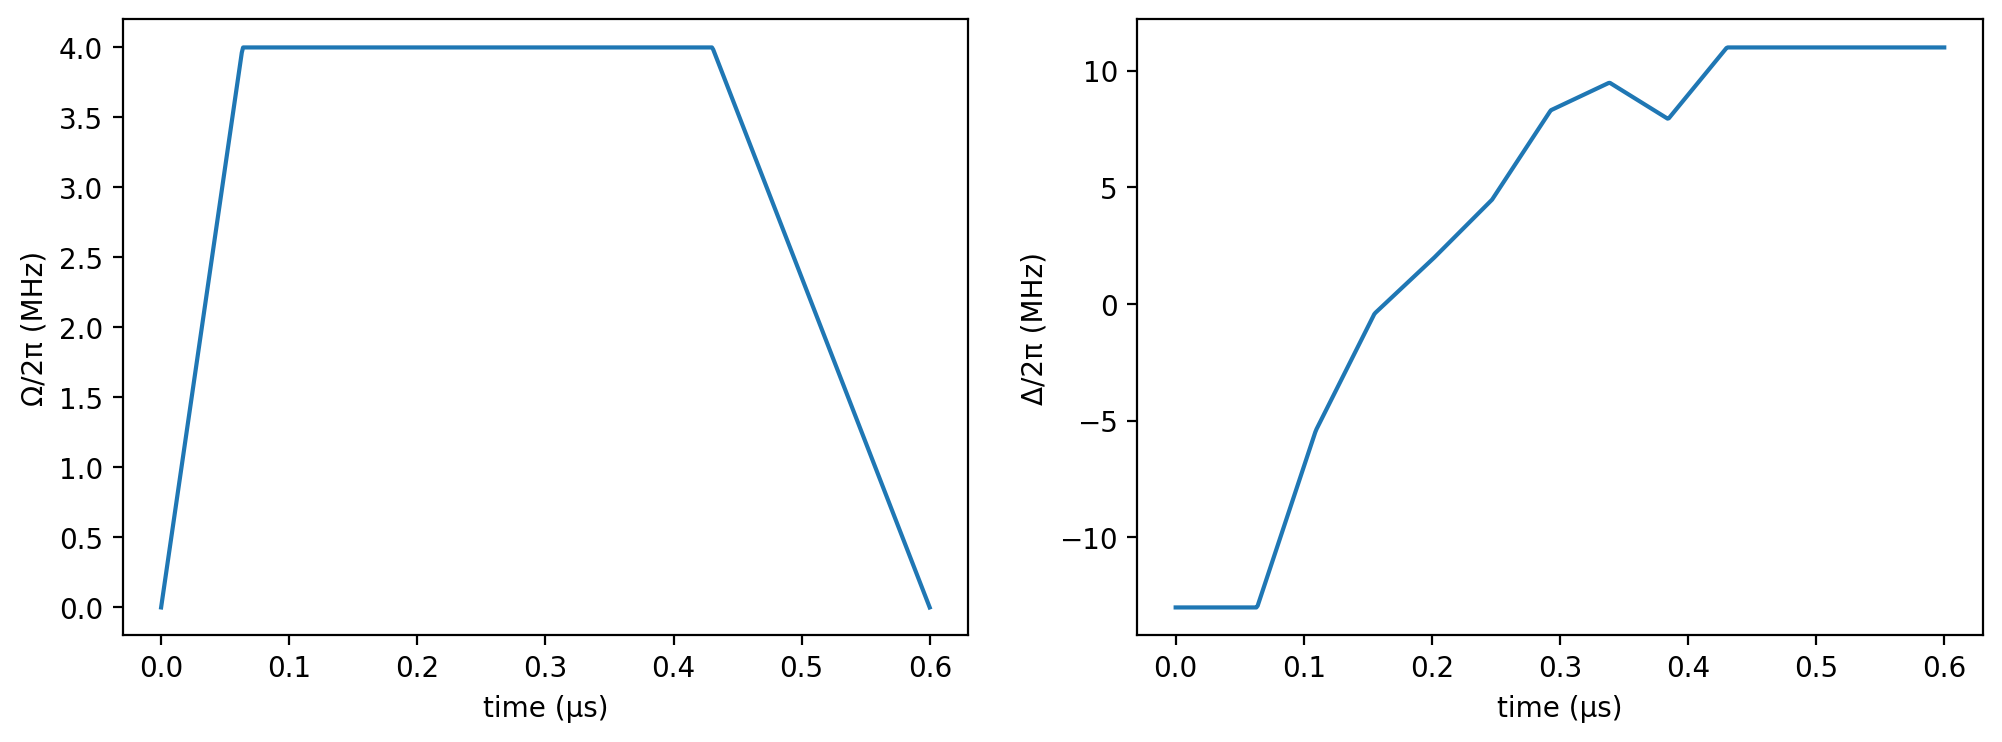

In [26]:
plot_waves(optresult.minimizer)

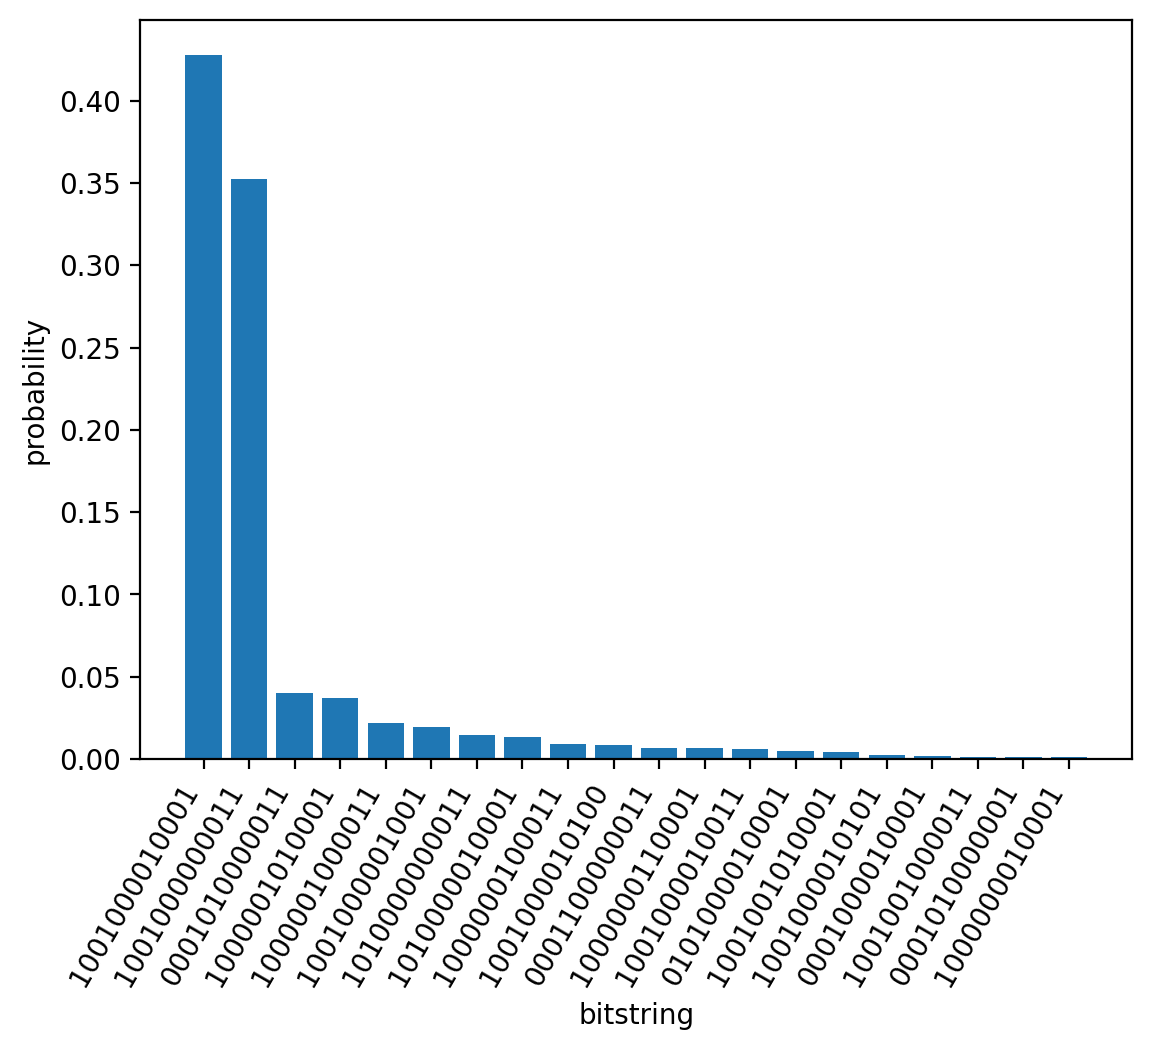

In [33]:
Ω, Δ = get_waves(optresult.minimizer)
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ=Waveform(t->0.0, T_max))
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

bitstring_hist(prob.reg; nlargest = 20)

In [36]:
dump(Ω)


Waveform{BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Vector{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}, Float64}
  f: BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Vector{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}
    clocks: Array{Float64}((4,)) [0.0, 0.06357583193183808, 0.43035713178212187, 0.6]
    values: Array{Float64}((4,)) [0.0, 25.132741228718345, 25.132741228718345, 0.0]
    interp: Interpolations.E

In [37]:
dump(Δ)

Waveform{BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Vector{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}, Float64}
  f: BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Vector{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}
    clocks: Array{Float64}((11,)) [0.0, 0.06357583193183808, 0.10942349441312355, 0.155271156894409, 0.2011188193756945, 0.24696648185697997, 0.29281414433826547, 0.33866180681955094, 0.384509469300